In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [3]:
df = pd.read_csv('/kaggle/input/speed-dating/speeddating.csv')

In [4]:
# Drop all that related to night, it dont need to me
df.drop(['d_attractive_partner', 'd_sincere_partner', 'd_intelligence_partner', 'd_funny_partner', 
         'd_shared_interests_partner', 'd_ambition_partner', 
         'decision', 'decision_o', 'attractive_o', 'd_sincere_partner', 'intelligence_o',
         'funny_o', 'ambitous_o', 'shared_interests_o', 'd_ambitous_o', 
         'd_attractive_o', 'd_intelligence_o', 'd_expected_happy_with_sd_people',
         'd_expected_num_interested_in_me', 'd_expected_num_matches',
         'd_funny_o', 'd_ambitous_o', 'd_shared_interests_o', 'd_like', 'd_guess_prob_liked',
         'sinsere_o', 'd_sinsere_o'], axis=1, inplace=True)

In [5]:
# Drop all features that need opinion of 'user' about partner and backward
df.drop(['attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner',
         'ambition_partner', 'shared_interests_partner', 'expected_happy_with_sd_people',
         'expected_num_interested_in_me', 'expected_num_matches', 'like', 
         'guess_prob_liked', 'met'], axis=1, inplace=True)

In [6]:
# Garbage that don't need to me
df.drop(['has_null', 'wave', ], axis = 1, inplace = True)

In [7]:
df.dropna(inplace = True)


In [8]:
from sklearn.preprocessing import OrdinalEncoder

for col in df.columns:
    if df[col].dtype == "object":
        oe = OrdinalEncoder()
        df[col] = oe.fit_transform(df[[col]])


In [22]:
def is_binary_byte_column(col_series: pd.Series) -> bool:
    # drop nans and take uniqs
    uniques = set(col_series.dropna().unique())
    return uniques.issubset({"b'0'", "b'1'"})

binary_cols = []
for col in df.columns:
    if is_binary_byte_column(df[col]):
        binary_cols.append(col)

# drop b' ' and convert to (0 или 1)
for col in binary_cols:
    df[col] = (
        df[col]
        .astype(str) 
        .str.extract(r"b'([01])'")[0] 
        .astype(int)
    )

# check
print("Найдено бинарных b'0'/b'1' столбцов:", binary_cols)
print(df.head())

Найдено бинарных b'0'/b'1' столбцов: ['samerace', 'match']
      gender   age  age_o  d_age   d_d_age  \
0  b'female'  21.0   27.0    6.0  b'[4-6]'   
1  b'female'  21.0   22.0    1.0  b'[0-1]'   
2  b'female'  21.0   22.0    1.0  b'[0-1]'   
3  b'female'  21.0   23.0    2.0  b'[2-3]'   
4  b'female'  21.0   24.0    3.0  b'[2-3]'   

                                       race  \
0  b'Asian/Pacific Islander/Asian-American'   
1  b'Asian/Pacific Islander/Asian-American'   
2  b'Asian/Pacific Islander/Asian-American'   
3  b'Asian/Pacific Islander/Asian-American'   
4  b'Asian/Pacific Islander/Asian-American'   

                                     race_o  samerace  importance_same_race  \
0            b'European/Caucasian-American'         0                   2.0   
1            b'European/Caucasian-American'         0                   2.0   
2  b'Asian/Pacific Islander/Asian-American'         1                   2.0   
3            b'European/Caucasian-American'         0            

In [41]:
from sklearn.model_selection import train_test_split

X = df.drop(['match'], axis=1)
y = df['match']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.209, random_state=0)

0.2293

In [42]:
from xgboost import XGBClassifier

xgb = XGBClassifier(gamma=0.0012855593559391036,
                    learning_rate=0.007201845955983364,
                    max_depth=7,
                    n_estimators=473,
                    reg_alpha=0.17424427381982702,
                    reg_lambda=0.042411516829332606,
                    subsample=0.5534371642481966,
                    colsample_bytree=0.7020244485810889,
                    eval_metric='logloss',
                    random_state=42,
                    booster='gbtree')


xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7020244485810889, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.0012855593559391036, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.007201845955983364, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=473, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [43]:
print(f'accuracy: {accuracy_score(xgb.predict(X_val), y_val)}\nf1 score: {f1_score(xgb.predict(X_val), y_val, average="micro")}')

accuracy: 0.8367952522255193
f1 score: 0.8367952522255193


In [45]:
# === 2. Получение массива feature_importances_ ===
# После обучения в xgb.feature_importances_ хранится NumPy-массив весов
# (который по умолчанию базируется на суммарном приросте качества при разделении — gain).
importances_array = xgb.feature_importances_

# Чтобы сопоставить силу признака с его именем:
feature_names = X_train.columns
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances_array
}).sort_values(by='importance', ascending=False)

print("Feature importances (по умолчанию):")
print(feat_imp)

Feature importances (по умолчанию):
                       feature  importance
69                       d_art    0.015745
33    d_intellicence_important    0.014619
30  shared_interests_important    0.014590
35       d_ambtition_important    0.014384
42                d_attractive    0.013812
..                         ...         ...
20            d_pref_o_sincere    0.010402
71                    d_gaming    0.010349
74                        d_tv    0.010329
82       d_interests_correlate    0.009609
23          d_pref_o_ambitious    0.009237

[83 rows x 2 columns]


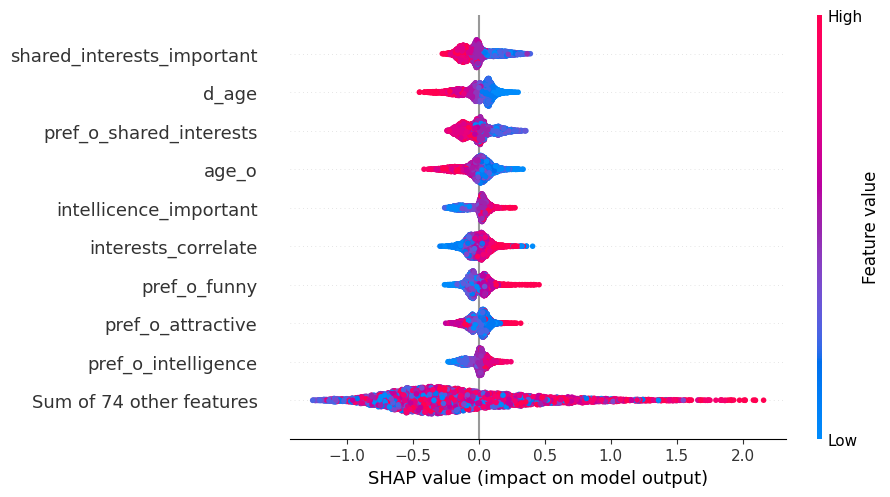

In [49]:
import shap
explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)